In [17]:
# adding required packages
import findspark
import pprint
import matplotlib.pyplot as plt

In [18]:
# To make pyspark importable as a regular library
findspark.init()

In [60]:
#importing pyspark related package
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.functions import col, when, avg, round, rank, isnan, current_timestamp, date_sub, sum, desc
from pyspark.sql.window import Window

In [57]:
%run /notebook/dataproduct/assesment_nyc_job_posting/lib/data_profiling_transform.ipynb

Data profile Function Imported


In [66]:
%run /notebook/dataproduct/assesment_nyc_job_posting/lib/kpi_transform.ipynb

KPI Transformations Imported


In [22]:
%run /notebook/dataproduct/assesment_nyc_job_posting/utils/spark_session.ipynb

Spark Session Imported


In [23]:
def get_spark_conf():
    # Configure Spark settings
    spark_conf = SparkConf()
    spark_conf.set("spark.executor.instances", "4") # 4 instance per node

    # Set the number of executor cores
    spark_conf.set("spark.executor.cores", "2")  # Use 2 cores per executor

    # Set the executor memory
    spark_conf.set("spark.executor.memory", "1g")  # Use 1GB memory per executor

    # Set the driver memory
    spark_conf.set("spark.driver.memory", "2g")    # Use 2GB memory for the driver
    
    return spark_conf

## Creating Spark Session

In [24]:
job_name = 'nyc_assesment'
    
#setting spark conf before creating spark session
spark_conf = get_spark_conf()

# Create a SparkSession with the configured settings
spark = get_spark_session(spark_conf, job_name)

# Listing all the spark conf
spark.sparkContext.getConf().getAll()

# setting spark conf for analysis
spark.conf.set('spark.sql.repl.eagerEval.enabled',True)

## Reading Dataset

In [25]:
#reading dataset
# adding escape charater after data profiling the data 
df = spark.read.csv("/dataset/nyc-jobs.csv", header=True, inferSchema=True, escape='"')

In [26]:
# reducing the shuffle partition to 4 
# reason 1 data size is very less
# reason 2 to use all the availble cores
# reason 3 Since data size is very small and can be fitted in single partition but using 4 just to show data shuffling
spark.conf.set('spark.sql.shuffle.partitions',4)

## Data Profiling

In [27]:
#getting the schema
df.printSchema()

root
 |-- Job ID: integer (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Posting Type: string (nullable = true)
 |-- # Of Positions: integer (nullable = true)
 |-- Business Title: string (nullable = true)
 |-- Civil Service Title: string (nullable = true)
 |-- Title Code No: string (nullable = true)
 |-- Level: string (nullable = true)
 |-- Job Category: string (nullable = true)
 |-- Full-Time/Part-Time indicator: string (nullable = true)
 |-- Salary Range From: double (nullable = true)
 |-- Salary Range To: double (nullable = true)
 |-- Salary Frequency: string (nullable = true)
 |-- Work Location: string (nullable = true)
 |-- Division/Work Unit: string (nullable = true)
 |-- Job Description: string (nullable = true)
 |-- Minimum Qual Requirements: string (nullable = true)
 |-- Preferred Skills: string (nullable = true)
 |-- Additional Information: string (nullable = true)
 |-- To Apply: string (nullable = true)
 |-- Hours/Shift: string (nullable = true)
 |-- Work Locat

In [28]:
## Display the first few rows of the DataFrame
display(df.limit(10))

Job ID,Agency,Posting Type,# Of Positions,Business Title,Civil Service Title,Title Code No,Level,Job Category,Full-Time/Part-Time indicator,Salary Range From,Salary Range To,Salary Frequency,Work Location,Division/Work Unit,Job Description,Minimum Qual Requirements,Preferred Skills,Additional Information,To Apply,Hours/Shift,Work Location 1,Recruitment Contact,Residency Requirement,Posting Date,Post Until,Posting Updated,Process Date
87990,DEPARTMENT OF BUS...,Internal,1,Account Manager,CONTRACT REVIEWER...,40563,1,null,null,42405.0,65485.0,Annual,110 William St. N Y,Strategy & Analytics,Division of Econo...,1. A baccalaureat...,â€¢ Excellent int...,Salary range for ...,null,null,null,null,New York City res...,2011-06-24 00:00:00,null,2011-06-24 00:00:00,2019-12-17 00:00:00
97899,DEPARTMENT OF BUS...,Internal,1,EXECUTIVE DIRECTO...,ADMINISTRATIVE BU...,10009,M3,null,F,60740.0,162014.0,Annual,110 William St. N Y,Tech Talent Pipeline,The New York City...,1. A baccalaureat...,null,null,In addition to ap...,null,null,null,New York City res...,2012-01-26 00:00:00,null,2012-01-26 00:00:00,2019-12-17 00:00:00
132292,NYC HOUSING AUTHO...,External,52,Maintenance Worke...,MAINTENANCE WORKER,90698,0,Maintenance & Ope...,F,51907.68,54580.32,Annual,Heating Mgt-Opera...,Management Servic...,Under direct supe...,1. Three years of...,1. A High School...,1. A Motor Vehic...,"Click the ""Apply ...",null,null,null,NYCHA has no resi...,2013-10-24 00:00:00,null,2013-12-12 00:00:00,2019-12-17 00:00:00
132292,NYC HOUSING AUTHO...,Internal,52,Maintenance Worke...,MAINTENANCE WORKER,90698,0,Maintenance & Ope...,F,51907.68,54580.32,Annual,Heating Mgt-Opera...,Management Servic...,Under direct supe...,1. Three years of...,1. A High School...,1. A Motor Vehic...,"Click the ""Apply ...",null,null,null,NYCHA has no resi...,2013-10-24 00:00:00,null,2013-12-12 00:00:00,2019-12-17 00:00:00
133921,NYC HOUSING AUTHO...,Internal,50,Temporary Painter,PAINTER,91830,0,Maintenance & Ope...,F,35.0,35.0,Hourly,DMP-Contract & An...,Dept of Managemen...,Responsibilities ...,1. Five years of ...,null,SPECIAL NOTE: ...,"Click the ""Apply ...",null,null,null,NYCHA has no resi...,2014-01-09 00:00:00,null,2014-01-08 00:00:00,2019-12-17 00:00:00
133921,NYC HOUSING AUTHO...,External,50,Temporary Painter,PAINTER,91830,0,Maintenance & Ope...,F,35.0,35.0,Hourly,DMP-Contract & An...,Dept of Managemen...,Responsibilities ...,1. Five years of ...,null,SPECIAL NOTE: ...,"Click the ""Apply ...",null,null,null,NYCHA has no resi...,2014-01-09 00:00:00,null,2014-01-08 00:00:00,2019-12-17 00:00:00
137433,DEPT OF HEALTH/ME...,Internal,1,Contract Analyst,PROCUREMENT ANALYST,12158,3,"Finance, Accounti...",F,50598.0,85053.0,Annual,42-09 28th Street,HIV Administration,** OPEN TO PERMAN...,1. A baccalaureat...,Strong analytical...,null,Apply online with...,null,42-09 28th Street...,null,New York City res...,2013-12-09 00:00:00,null,2013-12-09 00:00:00,2019-12-17 00:00:00
138531,DEPT OF ENVIRONME...,Internal,1,Associate Chemist,ASSOCIATE CHEMIST,21822,2,Health Public Saf...,F,50623.0,75083.0,Annual,96-05 Horace Hard...,DWOC Labs-Lefrak,Working in the Di...,Qualification Req...,In order to apply...,null,"Click the ""Apply ...",35 Hours per week...,96-05 Horace Hard...,null,New York City res...,2013-12-20 00:00:00,null,2014-07-25 00:00:00,2019-12-17 00:00:00
151131,NYC HOUSING AUTHO...,External,1,Cost Estimating M...,ADMINISTRATIVE ST...,1002D,0,"Engineering, Arch...",F,90000.0,110000.0,Annual,CP Cap Plan-Techn...,Capital Planning ...,Reporting to the ...,1. A master's deg...,1. Five years of...,SPECIAL INSTRUCTI...,"Click the ""Apply ...",null,null,null,NYCHA has no resi...,2014-06-25 00:00:00,null,2014-07-07 00:00:00,2019-12-17 00:00:00
152738,LAW DEPARTMENT,Internal,1,Office Manager,CLERICAL ASSOCIATE,10251,3,Clerical & Admini...,F,30683.0,49707.0,Annual,"100 Church St., N.Y.",Appeals,Performs essentia...,Qualification Req...,Experience with L...,Candidates must b...,Please click the ...,Monday

In [29]:
# Getting counts
total_count = df.count()
print(f"Total Records: {total_count}")

Total Records: 2946


In [30]:
# Dropping duplicates
df = df.distinct()
dist_tot_cnt = df.count()
print(f"Total Records after removing duplicates: {dist_tot_cnt}")

Total Records after removing duplicates: 2915


In [73]:
print("Getting missing value counts")
missing_value_counts = calculate_missing_value_counts(df)
missing_value_counts.show(vertical=True)

Getting missing value counts
-RECORD 0-------------------------------------
 Job ID_missing                        | 0    
 Agency_missing                        | 0    
 Posting Type_missing                  | 0    
 # Of Positions_missing                | 0    
 Business Title_missing                | 0    
 Civil Service Title_missing           | 0    
 Title Code No_missing                 | 0    
 Level_missing                         | 0    
 Job Category_missing                  | 2    
 Full-Time/Part-Time indicator_missing | 193  
 Salary Range From_missing             | 0    
 Salary Range To_missing               | 0    
 Salary Frequency_missing              | 0    
 Work Location_missing                 | 0    
 Division/Work Unit_missing            | 0    
 Job Description_missing               | 0    
 Minimum Qual Requirements_missing     | 20   
 Preferred Skills_missing              | 387  
 Additional Information_missing        | 1087 
 To Apply_missing              

In [32]:
print("Getting numerical status")
numerical_columns = [col_name for col_name, col_type in df.dtypes if col_type in ["int", "double", "float"]]
summary_stats = calculate_summary_stats(df, numerical_columns)
display(summary_stats)

Getting numerical status


summary,Job ID,# Of Positions,Salary Range From,Salary Range To
mean,384863.0401372213,2.4363636363636365,58925.98743831904,85653.82161382504
stddev,53017.48027901089,8.58105496276755,27018.915415806176,42923.02678547604
min,87990,1,0.0,10.36
max,426238,200,218587.0,234402.0


Getting categorical columns
Column: Posting Type
Distinct Values: 2
Top Values:
+------------+-----+
|Posting Type|count|
+------------+-----+
|Internal    |1653 |
|External    |1262 |
+------------+-----+



<Figure size 576x432 with 0 Axes>

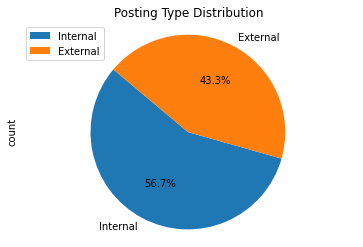

Column: Full-Time/Part-Time indicator
Distinct Values: 3
Top Values:
+-----------------------------+-----+
|Full-Time/Part-Time indicator|count|
+-----------------------------+-----+
|F                            |2597 |
|null                         |193  |
|P                            |125  |
+-----------------------------+-----+



<Figure size 576x432 with 0 Axes>

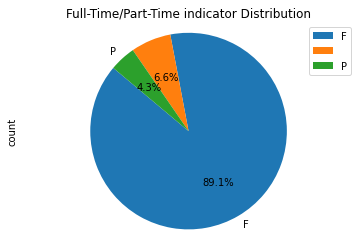

Column: Salary Frequency
Distinct Values: 3
Top Values:
+----------------+-----+
|Salary Frequency|count|
+----------------+-----+
|Annual          |2683 |
|Hourly          |194  |
|Daily           |38   |
+----------------+-----+



<Figure size 576x432 with 0 Axes>

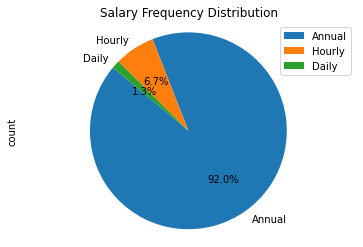

Column: Recruitment Contact
Distinct Values: 1
Top Values:
+-------------------+-----+
|Recruitment Contact|count|
+-------------------+-----+
|null               |2915 |
+-------------------+-----+



<Figure size 576x432 with 0 Axes>

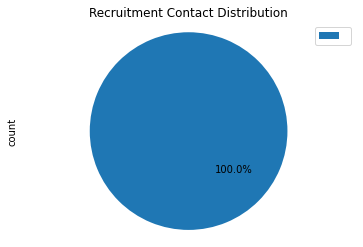

Column: Process Date
Distinct Values: 2
Top Values:
+-------------------+-----+
|Process Date       |count|
+-------------------+-----+
|2019-12-17 00:00:00|2911 |
|null               |4    |
+-------------------+-----+



<Figure size 576x432 with 0 Axes>

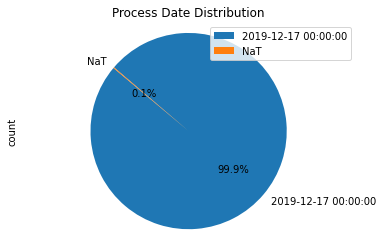

In [33]:
print("Getting categorical columns") 
# Most of the time categorical column should be string type but for this analysis -
# assuming that categorical columns can be any type.
distinct_threshold=10
for col_name in df.columns:
    is_categorical_cond, distinct_values, top_values = profile_categorical_column(df, col_name)
    if is_categorical_cond:
        print(f"Column: {col_name}")
        print(f"Distinct Values: {distinct_values}")
        print("Top Values:")
        top_values.show(truncate=False)
        pandas_df = top_values.toPandas()
        # Plot the pie chart using Pandas
        plt.figure(figsize=(8, 6))
        pandas_df.plot.pie(y="count", labels=pandas_df[f"{col_name}"], autopct="%1.1f%%", startangle=140)
        plt.axis("equal")
        plt.title(f"{col_name} Distribution")
        plt.show();


## Data Preparation

In [38]:
print("Preparing Data for KPI")

# Normalizing the salary to annual level
kpi_pre_df = df.withColumn("Annual Salary From",
                   when(col("Salary Frequency") == "Hourly", col("Salary Range From") * 2080)  # Assuming 2080 work hours per year
                   .when(col("Salary Frequency") == "Weekly", col("Salary Range From") * 52)
                   .when(col("Salary Frequency") == "Daily", col("Salary Range From") * 260)  # Assuming 5 workdays per week
                   .otherwise(col("Salary Range From")))

kpi_df = kpi_pre_df.withColumn("Annual Salary To",
                   when(col("Salary Frequency") == "Hourly", col("Salary Range To") * 2080)
                   .when(col("Salary Frequency") == "Weekly", col("Salary Range To") * 52)
                   .when(col("Salary Frequency") == "Daily", col("Salary Range To") * 260)
                   .otherwise(col("Salary Range To")))



Preparing Data for KPI


## Generating KPIs

In [61]:
print("Top 10 jobs posting per category")
category_counts = get_top10_job_posting_per_cat(kpi_df)
category_counts.show(truncate=False)

Top 10 jobs posting per category
+-----------------------------------------+--------------+
|Job Category                             |No_Of_Position|
+-----------------------------------------+--------------+
|Building Operations & Maintenance        |1234          |
|Public Safety, Inspections, & Enforcement|1205          |
|Engineering, Architecture, & Planning    |755           |
|Legal Affairs                            |513           |
|Technology, Data & Innovation            |404           |
|Health                                   |358           |
|Administration & Human Resources         |321           |
|Finance, Accounting, & Procurement       |274           |
|Maintenance & Operations                 |212           |
|Policy, Research & Analysis              |200           |
+-----------------------------------------+--------------+



In [44]:
print("The salary distribution per job category")
salary_distribution = get_sal_dist_per_cat(kpi_df)
salary_distribution.limit(10).show(truncate=False,vertical=True)

The salary distribution per job category
-RECORD 0------------------------------------------------------------------------------------------------------------------------------------------------------
 Job Category  | null                                                                                                                                          
 AvgSalaryFrom | 51572.5                                                                                                                                       
 AvgSalaryTo   | 113749.5                                                                                                                                      
-RECORD 1------------------------------------------------------------------------------------------------------------------------------------------------------
 Job Category  | Administration & Human Resources                                                                                                              

In [67]:
print("The job posting having the highest salary per agency")
max_sal_per_agency_df = get_highes_sal_per_cat(kpi_df)
max_sal_per_agency_df.show(truncate=False)

The job posting having the highest salary per agency
+------------------------------+------------------------------------------------------------+--------------+
|Agency                        |Business Title                                              |Highest Salary|
+------------------------------+------------------------------------------------------------+--------------+
|DEPARTMENT OF BUILDINGS       |Borough Enforcement Attorney                                |82137.0       |
|DEPARTMENT OF FINANCE         |Senior Director                                             |140000.0      |
|DEPT. OF HOMELESS SERVICES    |DHS OVERDOSE PREVENTION COORDINATOR                         |92001.0       |
|FIRE DEPARTMENT               |Senior Enterprise Applications Integration Developer        |144929.0      |
|HOUSING PRESERVATION & DVLPMNT|Assistant Commissioner of Community Partnerships and Finance|140000.0      |
|HRA/DEPT OF SOCIAL SERVICES   |EXECUTIVE DIRECTOR, SERVER INFRASTRUCTURE -

In [72]:
#KPI5: Whats the job positings average salary per agency for the last 2 years
print("The average salary per agency for the last 2 years")
last_n_year = 4
avg_salary_df = get_avg_sal_per_agency_last_n_year(kpi_df,last_n_year)
avg_salary_df.show(truncate=False)

The average salary per agency for the last 2 years
+------------------------------+----------------------+--------------------+
|Agency                        |Avg_Annual_Salary_From|Avg_Annual_Salary_To|
+------------------------------+----------------------+--------------------+
|FIRE DEPARTMENT               |79965.98              |93000.73            |
|OFFICE OF MANAGEMENT & BUDGET |67435.17              |79186.17            |
|HOUSING PRESERVATION & DVLPMNT|74863.93              |85905.52            |
|DEPARTMENT OF FINANCE         |68758.75              |90428.92            |
|HRA/DEPT OF SOCIAL SERVICES   |62180.88              |86805.46            |
|DEPT. OF HOMELESS SERVICES    |39082.0               |55301.67            |
|DEPARTMENT OF BUILDINGS       |45581.47              |55310.6             |
|TEACHERS RETIREMENT SYSTEM    |62397.0               |75760.0             |
|DEPT OF HEALTH/MENTAL HYGIENE |61872.37              |79865.25            |
|DEPT OF INFO TECH & TELE

In [74]:
spark.stop()